In [1]:
### seasonal cycle - preindustrial sea ice
### last updated June 28, 2021
### author: Jennifer.E.Kay@colorado.edu

# libraries
from pathlib import Path 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from matplotlib.gridspec import GridSpec  #for multipanel plots
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.crs as crt
from matplotlib.gridspec import GridSpec

In [2]:
# read in the pre-processed data
outpath='/glade/work/jenkay/tunedice/original/'

### CESM2
outfile='b.e21.B1850.f09_g17.CMIP6-piControl.001.cice.h.aice.mtimeseries.nc'
ds_aice = xr.open_mfdataset(outpath+outfile)
aice_all=ds_aice.aice
outfile='b.e21.B1850.f09_g17.CMIP6-piControl.001.cice.h.hi.mtimeseries.nc'
ds_hi = xr.open_mfdataset(outpath+outfile)
hi_all=ds_hi.hi

### CESM2 tuned ice
outfile_tuned='b.e21.B1850.f09_g17.CMIP6-piControl.001_branch2.cice.h.aice.mtimeseries.nc'
ds_aice_tuned = xr.open_mfdataset(outpath+outfile_tuned)
aice_tuned_all=ds_aice_tuned.aice
outfile_tuned='b.e21.B1850.f09_g17.CMIP6-piControl.001_branch2.cice.h.hi.mtimeseries.nc'
ds_tuned_hi = xr.open_mfdataset(outpath+outfile_tuned)
hi_tuned_all=ds_tuned_hi.hi

## coordinates
tarea=ds_aice_tuned.tarea
tlat=ds_aice_tuned.TLAT
tlon=ds_aice_tuned.TLON

In [3]:
## check data
#print(aice_all)
#print(aice_tuned_all)
#print(hi_all)
#print(hi_tuned_all)

In [3]:
## fix time so that months are labelled as starting in January not February

tbounds=ds_aice['time_bounds'].isel(d2=0) ## pick out the beginning of the time bound
print(tbounds.shape)
aice_all['time'].values=tbounds.values
hi_all['time'].values=tbounds.values

tbounds=ds_aice_tuned['time_bounds'].isel(d2=0) ## pick out the beginning of the time bound
print(tbounds.shape)
aice_tuned_all['time'].values=tbounds.values
hi_tuned_all['time'].values=tbounds.values

print(aice_all['time'])
print(aice_tuned_all['time'])

(14400,)
(6720,)
<xarray.DataArray 'time' (time: 14400)>
array([cftime.DatetimeNoLeap(1, 1, 1, 0, 0, 0, 0, 1, 1),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, 4, 32),
       cftime.DatetimeNoLeap(1, 3, 1, 0, 0, 0, 0, 4, 60), ...,
       cftime.DatetimeNoLeap(1200, 10, 1, 0, 0, 0, 0, 3, 274),
       cftime.DatetimeNoLeap(1200, 11, 1, 0, 0, 0, 0, 6, 305),
       cftime.DatetimeNoLeap(1200, 12, 1, 0, 0, 0, 0, 1, 335)], dtype=object)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 1200-12-01 00:00:00
Attributes:
    long_name:  model time
    bounds:     time_bounds
<xarray.DataArray 'time' (time: 6720)>
array([cftime.DatetimeNoLeap(811, 1, 1, 0, 0, 0, 0, 6, 1),
       cftime.DatetimeNoLeap(811, 2, 1, 0, 0, 0, 0, 2, 32),
       cftime.DatetimeNoLeap(811, 3, 1, 0, 0, 0, 0, 2, 60), ...,
       cftime.DatetimeNoLeap(1370, 10, 1, 0, 0, 0, 0, 5, 274),
       cftime.DatetimeNoLeap(1370, 11, 1, 0, 0, 0, 0, 1, 305),
       cftime.DatetimeNoLeap(1370, 12, 1, 0, 0, 0, 0, 3, 335)

In [4]:
## subset time
#aice_tuned=aice_tuned_all
#aice=aice_all

tstart='0911-01'
tend='1110-12'

aice_tuned=aice_tuned_all.sel(time=slice(tstart,tend))
hi_tuned=hi_tuned_all.sel(time=slice(tstart,tend))

aice=aice_all.sel(time=slice(tstart,tend))
hi=hi_all.sel(time=slice(tstart,tend))
#print(aice['time'])
#print(aice_tuned['time'])
print(aice['time'].shape)
print(aice_tuned['time'].shape)
print(hi['time'].shape)
print(hi_tuned['time'].shape)
print(2400/12)

(2400,)
(2400,)
(2400,)
(2400,)
200.0


In [5]:
### Check data values to make sure they look ok

# this slice is good for Chukchi
print(aice.isel(nj=slice(333,343),ni=slice(194,204)).mean(dim=['nj','ni','time']).values)
print(hi.isel(nj=slice(333,343),ni=slice(194,204)).mean(dim=['nj','ni','time']).values)
print(aice_tuned.isel(nj=slice(333,343),ni=slice(194,204)).mean(dim=['nj','ni','time']).values)
print(hi_tuned.isel(nj=slice(333,343),ni=slice(194,204)).mean(dim=['nj','ni','time']).values)

0.53546166
0.9058948
0.58447015
1.1601627


In [6]:
### Calculate the monthly mean extent, area, and volume in the CESM2
## [14.19 14.83 15.08 14.88 14.02 12.46 10.54  8.19  7.13  8.77 10.85 12.94] are values over the entire run - years 1-1200

## extent
extent_threshold=0.15
ext=np.where(aice>extent_threshold,1.0,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(ext.shape)
ext_nh = np.where(tlat>0,ext,0)
ext_sh = np.where(tlat<0,ext,0)
#print(ext_nh.shape)
ext_mo_nh=np.sum(np.sum(ext_nh,axis=1),axis=1)*1.0e-12
ext_mo_sh=np.sum(np.sum(ext_sh,axis=1),axis=1)*1.0e-12
#print(ext_mo_nh.shape)
nyrs=np.int(np.size(ext_mo_nh)/12)
ext_nh_mean=np.average(np.reshape(ext_mo_nh,[nyrs,12]),axis=0)
#ext_nh_mean.shape
ext_sh_mean=np.average(np.reshape(ext_mo_sh,[nyrs,12]),axis=0)
print(np.round(ext_nh_mean,2))
print(np.round(ext_sh_mean,2))

## area
area=np.where(aice>0,aice,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(area.shape)
area_nh = np.where(tlat>0,area,0)
area_sh = np.where(tlat<0,area,0)
#print(area_nh.shape)
area_mo_nh=np.sum(np.sum(area_nh,axis=1),axis=1)*1.0e-12
area_mo_sh=np.sum(np.sum(area_sh,axis=1),axis=1)*1.0e-12
#print(area_mo_nh.shape)
#print(area_mo_nh)
nyrs=np.int(np.size(area_mo_nh)/12)
area_nh_mean=np.average(np.reshape(area_mo_nh,[nyrs,12]),axis=0)
area_sh_mean=np.average(np.reshape(area_mo_sh,[nyrs,12]),axis=0)
print(np.round(area_nh_mean,2))
print(np.round(area_sh_mean,2))

## volume
volume=np.where(aice>0,aice*hi,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(volume.shape)
volume_nh = np.where(tlat>0,volume,0)
volume_sh = np.where(tlat<0,volume,0)
#print(volume_nh.shape)
volume_mo_nh=np.sum(np.sum(volume_nh,axis=1),axis=1)*1.0e-13
volume_mo_sh=np.sum(np.sum(volume_sh,axis=1),axis=1)*1.0e-13
#print(volume_mo_nh.shape)
#print(volume_mo_nh)
nyrs=np.int(np.size(volume_mo_nh)/12)
volume_nh_mean=np.average(np.reshape(volume_mo_nh,[nyrs,12]),axis=0)
volume_sh_mean=np.average(np.reshape(volume_mo_sh,[nyrs,12]),axis=0)
print(np.round(volume_nh_mean,2))
print(np.round(volume_sh_mean,2))

/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


[14.11 14.72 14.95 14.76 13.94 12.41 10.41  8.02  6.91  8.62 10.74 12.85]
[ 8.78  4.27  5.    8.59 11.99 14.46 16.34 17.68 18.42 18.55 17.71 15.3 ]
[13.4  14.02 14.16 13.75 12.29 10.37  7.93  5.76  5.27  7.41  9.93 11.89]
[ 5.02  2.7   3.52  7.   10.41 12.79 14.42 15.52 15.96 15.47 13.66  9.97]


/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


[2.21 2.51 2.74 2.86 2.74 2.34 1.65 1.1  0.99 1.23 1.5  1.84]
[0.61 0.41 0.44 0.65 0.94 1.24 1.51 1.75 1.91 1.92 1.67 1.14]


In [8]:
### Calculate the monthly mean extent and area in the CESM2 tuned ice

## extent
ext_tuned=np.where(aice_tuned>extent_threshold,1.0,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(ext_tuned.shape)
ext_tuned_nh = np.where(tlat>0,ext_tuned,0)
ext_tuned_sh = np.where(tlat<0,ext_tuned,0)
#print(ext_tuned_nh.shape)
ext_tuned_mo_nh=np.sum(np.sum(ext_tuned_nh,axis=1),axis=1)*1.0e-12
ext_tuned_mo_sh=np.sum(np.sum(ext_tuned_sh,axis=1),axis=1)*1.0e-12
#print(ext_tuned_mo_nh.shape)
nyrs=np.int(np.size(ext_tuned_mo_nh)/12)
ext_tuned_nh_mean=np.average(np.reshape(ext_tuned_mo_nh,[nyrs,12]),axis=0)
ext_tuned_sh_mean=np.average(np.reshape(ext_tuned_mo_sh,[nyrs,12]),axis=0)
print(np.round(ext_tuned_nh_mean,2))
print(np.round(ext_tuned_sh_mean,2))

## area
area_tuned=np.where(aice_tuned>0,aice_tuned,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(area_tuned.shape)
area_tuned_nh = np.where(tlat>0,area_tuned,0)
area_tuned_sh = np.where(tlat<0,area_tuned,0)
#print(area_tuned_nh.shape)
area_tuned_mo_nh=np.sum(np.sum(area_tuned_nh,axis=1),axis=1)*1.0e-12
area_tuned_mo_sh=np.sum(np.sum(area_tuned_sh,axis=1),axis=1)*1.0e-12
#print(area_tuned_mo_nh.shape)
nyrs=np.int(np.size(area_tuned_mo_nh)/12)
area_tuned_nh_mean=np.average(np.reshape(area_tuned_mo_nh,[nyrs,12]),axis=0)
area_tuned_sh_mean=np.average(np.reshape(area_tuned_mo_sh,[nyrs,12]),axis=0)
print(np.round(area_tuned_nh_mean,2))
print(np.round(area_tuned_sh_mean,2))

## volume
volume_tuned=np.where(aice_tuned>0,aice_tuned*hi_tuned,0.0)*tarea.values  ##uses broadcasting, only works with .values
#print(volume_tuned.shape)
volume_tuned_nh = np.where(tlat>0,volume_tuned,0)
volume_tuned_sh = np.where(tlat<0,volume_tuned,0)
#print(volume_tuned_nh.shape)
volume_tuned_mo_nh=np.sum(np.sum(volume_tuned_nh,axis=1),axis=1)*1.0e-13
volume_tuned_mo_sh=np.sum(np.sum(volume_tuned_sh,axis=1),axis=1)*1.0e-13
#print(volume_tuned_mo_nh.shape)
#print(volume_tuned_mo_nh)
nyrs=np.int(np.size(volume_tuned_mo_nh)/12)
volume_tuned_nh_mean=np.average(np.reshape(volume_tuned_mo_nh,[nyrs,12]),axis=0)
volume_tuned_sh_mean=np.average(np.reshape(volume_tuned_mo_sh,[nyrs,12]),axis=0)
print(np.round(volume_tuned_nh_mean,2))
print(np.round(volume_tuned_sh_mean,2))

[14.27 14.86 15.11 14.93 14.15 12.61 10.98  8.78  7.83  9.25 11.07 13.08]
[10.01  5.32  5.95  9.53 12.81 15.19 17.02 18.33 19.05 19.16 18.39 16.05]
[13.55 14.16 14.31 13.93 12.56 10.72  8.55  6.65  6.31  8.11 10.32 12.17]
[ 5.86  3.47  4.38  7.88 11.19 13.46 15.02 16.07 16.47 15.96 14.17 10.62]


/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/glade/u/home/jenkay/miniconda3/envs/analysis_pyngl/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


[2.8  3.08 3.29 3.41 3.3  2.91 2.26 1.73 1.65 1.89 2.15 2.46]
[0.76 0.55 0.6  0.83 1.13 1.42 1.69 1.93 2.08 2.08 1.82 1.3 ]


Annual Mean Arctic Extent CESM2:          11.9
Annual Mean Arctic Area CESM2:            10.5
Annual Mean Arctic Extent CESM2-lessmelt: 12.2
Annual Mean Arctic Area CESM2-lessmelt    10.9
Annual Mean Arctic Volume CESM2:          2.0
Annual Mean Arctic Volume CESM2-lessmelt: 2.6


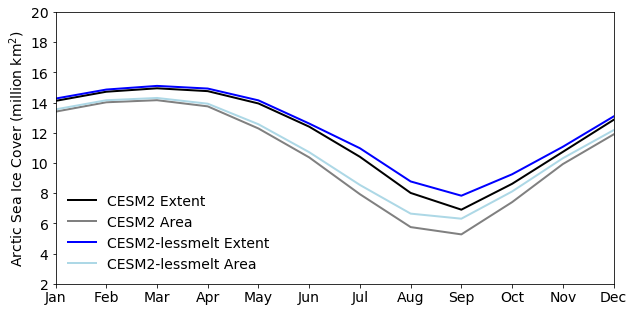

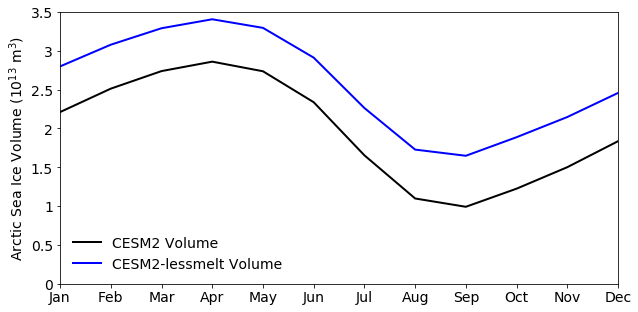

In [11]:
#### Arctic Plots

plt.figure(figsize = (10,5));
plt.plot(ext_nh_mean,color='black',linewidth=2,label='CESM2 Extent');
plt.plot(area_nh_mean,color='grey',linewidth=2,label='CESM2 Area');
plt.plot(ext_tuned_nh_mean,color='blue',linewidth=2,label='CESM2-lessmelt Extent');
plt.plot(area_tuned_nh_mean,color='lightblue',linewidth=2,label='CESM2-lessmelt Area');
plt.xlim([0,11]);
xticks=np.arange(0,12,1)
xlab=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(xticks,xlab,size='14')
plt.ylim([2,20]);
yticks=np.arange(2,22,2);
ylab=[2,4,6,8,10,12,14,16,18,20];
plt.yticks(yticks,ylab,size='14');
plt.ylabel('Arctic Sea Ice Cover (million km$^{2}$)',size=14);
plt.legend(loc='lower left',fontsize=14,edgecolor='None');

print('Annual Mean Arctic Extent CESM2:         ',np.str(np.round(ext_nh_mean.mean(),1)))
print('Annual Mean Arctic Area CESM2:           ',np.str(np.round(area_nh_mean.mean(),1)))
print('Annual Mean Arctic Extent CESM2-lessmelt:',np.str(np.round(ext_tuned_nh_mean.mean(),1)))
print('Annual Mean Arctic Area CESM2-lessmelt   ',np.str(np.round(area_tuned_nh_mean.mean(),1)))
plt.savefig('Arctic_mevol_extent_area.pdf',dpi=1200,format='pdf')

plt.figure(figsize = (10,5));
plt.plot(volume_nh_mean,color='black',linewidth=2,label='CESM2 Volume');
plt.plot(volume_tuned_nh_mean,color='blue',linewidth=2,label='CESM2-lessmelt Volume');
plt.xlim([0,11]);
xticks=np.arange(0,12,1)
xlab=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(xticks,xlab,size='14')
plt.ylim([0,3.5]);
yticks=np.arange(0,4.0,0.5);
ylab=[0,0.5,1,1.5,2,2.5,3,3.5];
plt.yticks(yticks,ylab,size='14');
plt.ylabel('Arctic Sea Ice Volume (10$^{13}$ m$^{3}$)',size=14);
plt.legend(loc='lower left',fontsize=14,edgecolor='None');

print('Annual Mean Arctic Volume CESM2:         ',np.str(np.round(volume_nh_mean.mean(),1)))
print('Annual Mean Arctic Volume CESM2-lessmelt:',np.str(np.round(volume_tuned_nh_mean.mean(),1)))
plt.savefig('Arctic_mevol_volume.pdf',dpi=1200,format='pdf')

Annual Mean Antarctic Extent CESM2:          13.1
Annual Mean Antarctic Area CESM2:            10.5
Annual Mean Antarctic Extent CESM2-lessmelt: 13.9
Annual Mean Antarctic Area CESM2-lessmelt    11.2
Annual Mean Antarctic Volume CESM2:          1.2
Annual Mean Antarctic Volume CESM2-lessmelt: 1.3


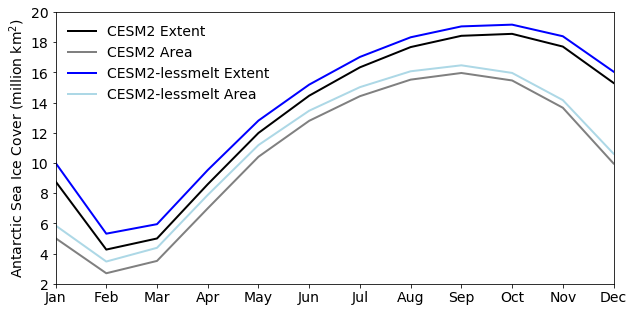

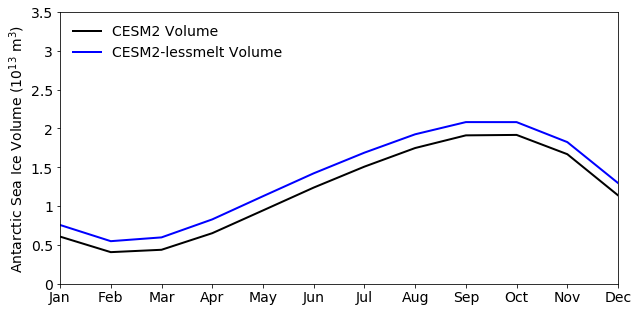

In [10]:
#### Antarctic Plots

plt.figure(figsize = (10,5));
plt.plot(ext_sh_mean,color='black',linewidth=2,label='CESM2 Extent');
plt.plot(area_sh_mean,color='grey',linewidth=2,label='CESM2 Area');
plt.plot(ext_tuned_sh_mean,color='blue',linewidth=2,label='CESM2-lessmelt Extent');
plt.plot(area_tuned_sh_mean,color='lightblue',linewidth=2,label='CESM2-lessmelt Area');
plt.xlim([0,11]);
xticks=np.arange(0,12,1)
xlab=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(xticks,xlab,size='14')
plt.ylim([2,20]);
yticks=np.arange(2,22,2);
ylab=[2,4,6,8,10,12,14,16,18,20];
plt.yticks(yticks,ylab,size='14');
plt.ylabel('Antarctic Sea Ice Cover (million km$^{2}$)',size=14);
plt.legend(loc='upper left',fontsize=14,edgecolor='None');

print('Annual Mean Antarctic Extent CESM2:         ',np.str(np.round(ext_sh_mean.mean(),1)))
print('Annual Mean Antarctic Area CESM2:           ',np.str(np.round(area_sh_mean.mean(),1)))
print('Annual Mean Antarctic Extent CESM2-lessmelt:',np.str(np.round(ext_tuned_sh_mean.mean(),1)))
print('Annual Mean Antarctic Area CESM2-lessmelt   ',np.str(np.round(area_tuned_sh_mean.mean(),1)))
plt.savefig('Antarctic_mevol_extent_area.pdf',dpi=1200,format='pdf')

plt.figure(figsize = (10,5));
plt.plot(volume_sh_mean,color='black',linewidth=2,label='CESM2 Volume');
plt.plot(volume_tuned_sh_mean,color='blue',linewidth=2,label='CESM2-lessmelt Volume');
plt.xlim([0,11]);
xticks=np.arange(0,12,1)
xlab=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(xticks,xlab,size='14')
plt.ylim([0,3.5]);
yticks=np.arange(0,4.0,0.5);
ylab=[0,0.5,1,1.5,2,2.5,3,3.5];
plt.yticks(yticks,ylab,size='14');
plt.ylabel('Antarctic Sea Ice Volume (10$^{13}$ m$^{3}$)',size=14);
plt.legend(loc='upper left',fontsize=14,edgecolor='None');

print('Annual Mean Antarctic Volume CESM2:         ',np.str(np.round(volume_sh_mean.mean(),1)))
print('Annual Mean Antarctic Volume CESM2-lessmelt:',np.str(np.round(volume_tuned_sh_mean.mean(),1)))
plt.savefig('Antarctic_mevol_volume.pdf',dpi=1200,format='pdf')